# Practico_9:  Encoding Avanzado y Target Encoding - Fill in the Blanks¶

📋 Lo que necesitas saber ANTES de empezar¶

Conceptos básicos de encoding categórico (label, one-hot)

Idea general de target encoding y data leakage

Uso de pipelines de scikit-learn

Conceptos de cross-validation

## 📦 Paso 0: Instalación de Dependencias¶


In [2]:
# === INSTALACIÓN DE DEPENDENCIAS ===

print("📦 Instalando dependencias necesarias...")
print("-" * 60)

# Instalar category_encoders (necesario para TargetEncoder)
%pip install shap category-encoders -q


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from category_encoders import TargetEncoder
import time
import warnings

print("\n🎉 Setup completado. Puedes continuar con el assignment.")


# Importar librerías necesarias
warnings.filterwarnings('ignore')

# Configuración
np.random.seed(42)
plt.style.use('seaborn-v0_8')  # establecer estilo visual
sns.set_palette("Set2")        # definir paleta de colores


print("✅ Entorno configurado para encoding avanzado")

📦 Instalando dependencias necesarias...
------------------------------------------------------------
Note: you may need to restart the kernel to use updated packages.

🎉 Setup completado. Puedes continuar con el assignment.
✅ Entorno configurado para encoding avanzado


## 💰 Paso 2: Cargar Dataset Real - Adult Income (Census)¶
📋 CONTEXTO DE NEGOCIO (CRISP-DM: Business Understanding)

🔗 Referencias oficiales:

Kaggle Feature Engineering - Target Encoding
Feature Engineering for ML - Cap. 5 (Categorical Variables)
Scikit-learn Preprocessing
Category Encoders Library
💰 Caso de negocio:

Problema: Predecir si el ingreso anual de una persona supera $50K basándose en datos del censo

Desafío: Variables categóricas con alta cardinalidad (occupation: 15 valores, native-country: 42 valores)

Objetivo: Comparar diferentes técnicas de encoding para maximizar la precisión del modelo de clasificación

Restricción: One-hot encoding genera 100+ columnas → curse of dimensionality

Valor: Modelos de segmentación de clientes, análisis de equidad salarial, políticas públicas

Contexto: Dataset real del US Census (1994) con 48,842 registros - clásico de ML

In [3]:
# === CARGAR DATASET REAL: ADULT INCOME ===

print("💰 CARGANDO DATASET: ADULT INCOME (US CENSUS)")
print("=" * 60)

# Este dataset es del UCI ML Repository - clásico para benchmarking
# Predice si el ingreso anual supera $50K basándose en datos del censo de 1994

# OPCIÓN 1: Cargar desde URL (si tienes conexión a internet)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Nombres de columnas (el dataset no tiene header)
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

df = pd.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)  # función para leer CSV

# 1. Limpiar datos
print("\n🧹 Limpiando datos...")

# Remover espacios en blanco de las categorías
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()  # método para eliminar espacios en blanco

# Manejar valores faltantes
print(f"   Valores faltantes antes: {df.isnull().sum().sum()}")
df = df.dropna(how='any')  # método para eliminar filas con NaN
print(f"   Valores faltantes después: {df.isnull().sum().sum()}")
print(f"   Registros después de limpieza: {len(df):,}")

# 2. Crear target binario
df['target'] = (df['income'] == '>50K').astype(int)

print(f"\n📊 Dataset shape: {df.shape}")
print(f"📊 Distribución del target:")
print(f"   <=50K: {(df['target']==0).sum():,} ({(df['target']==0).mean():.1%})")
print(f"   >50K:  {(df['target']==1).sum():,} ({(df['target']==1).mean():.1%})")

# 3. Identificar columnas categóricas (excluir target e income)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'income' in categorical_cols:
    categorical_cols.remove('income')
if 'target' in categorical_cols:
    categorical_cols.remove('target')

print(f"\n🔍 Variables categóricas encontradas: {len(categorical_cols)}")

# 4. Analizar cardinalidad
print("\n🔍 ANÁLISIS DE CARDINALIDAD:")
for col in categorical_cols:
    n_unique = df[col].nunique()
    cardinality_type = 'BAJA' if n_unique <= 10 else ('MEDIA' if n_unique <= 50 else 'ALTA')
    print(f"   {col}: {n_unique} categorías únicas ({cardinality_type})")

print("\n🔍 Primeras 5 filas:")
print(df.head())  # método para mostrar primeras filas

print("\n💡 CONTEXTO DEL DATASET:")
print("   Dataset del US Census (1994) - clásico de Machine Learning")
print("   Target: Ingreso >50K/año (clasificación binaria)")
print("   Variables categóricas: workclass, education, occupation, etc.")
print("   Alta cardinalidad: native-country (42 países)")
print("   Accuracy típica: 80-85% (más desafiante que hoteles)")

💰 CARGANDO DATASET: ADULT INCOME (US CENSUS)

🧹 Limpiando datos...
   Valores faltantes antes: 0
   Valores faltantes después: 0
   Registros después de limpieza: 32,561

📊 Dataset shape: (32561, 16)
📊 Distribución del target:
   <=50K: 24,720 (75.9%)
   >50K:  7,841 (24.1%)

🔍 Variables categóricas encontradas: 8

🔍 ANÁLISIS DE CARDINALIDAD:
   workclass: 9 categorías únicas (BAJA)
   education: 16 categorías únicas (MEDIA)
   marital-status: 7 categorías únicas (BAJA)
   occupation: 15 categorías únicas (MEDIA)
   relationship: 6 categorías únicas (BAJA)
   race: 5 categorías únicas (BAJA)
   sex: 2 categorías únicas (BAJA)
   native-country: 42 categorías únicas (MEDIA)

🔍 Primeras 5 filas:
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th      

## 🔢 Paso 3: Análisis de Cardinalidad¶



🔍 ANÁLISIS DE CARDINALIDAD
📊 CLASIFICACIÓN POR CARDINALIDAD:
✅ Baja cardinalidad (≤10): 5 columnas
   ['workclass', 'marital-status', 'relationship', 'race', 'sex']
⚠️  Media cardinalidad (11-50): 3 columnas
   ['education', 'occupation', 'native-country']
🚨 Alta cardinalidad (>50): 0 columnas
   []

🚨 PROBLEMA DE DIMENSIONALIDAD CON ONE-HOT:
   workclass: 9 categorías → 8 columnas one-hot
   education: 16 categorías → 15 columnas one-hot
   marital-status: 7 categorías → 6 columnas one-hot
   occupation: 15 categorías → 14 columnas one-hot
   relationship: 6 categorías → 5 columnas one-hot
   race: 5 categorías → 4 columnas one-hot
   sex: 2 categorías → 1 columnas one-hot
   native-country: 42 categorías → 41 columnas one-hot

❌ Total columnas con one-hot: 94
❌ Original: 8 columnas → 94 columnas
❌ Explosión dimensional: 11.8x


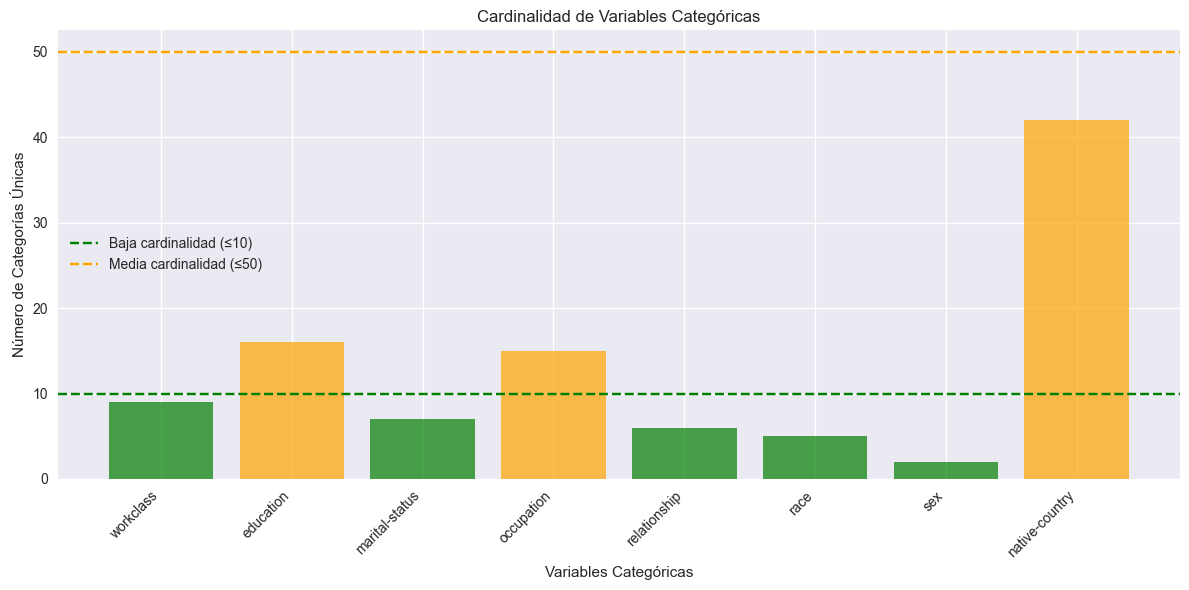


💡 CONCLUSIÓN:
   One-hot encoding NO es viable para variables de alta cardinalidad
   Necesitamos técnicas alternativas: Label, Target, Hash, Binary encoding


In [4]:
# === ANÁLISIS DE CARDINALIDAD Y PROBLEMAS DE ONE-HOT ===

print("\n🔍 ANÁLISIS DE CARDINALIDAD")
print("=" * 60)

# 1. Clasificar columnas por cardinalidad
def classify_cardinality(df, categorical_cols):
    """Clasificar columnas por cardinalidad"""
    low_card = []
    medium_card = []
    high_card = []

    for col in categorical_cols:
        n_unique = df[col].nunique()
        if n_unique <= 10:
            low_card.append(col)
        elif n_unique <= 50:
            medium_card.append(col)
        else:
            high_card.append(col)

    return low_card, medium_card, high_card

low_card_cols, medium_card_cols, high_card_cols = classify_cardinality(df, categorical_cols)

print("📊 CLASIFICACIÓN POR CARDINALIDAD:")
print(f"✅ Baja cardinalidad (≤10): {len(low_card_cols)} columnas")
print(f"   {low_card_cols}")
print(f"⚠️  Media cardinalidad (11-50): {len(medium_card_cols)} columnas")
print(f"   {medium_card_cols}")
print(f"🚨 Alta cardinalidad (>50): {len(high_card_cols)} columnas")
print(f"   {high_card_cols}")

# 2. Calcular dimensionalidad con One-Hot
print("\n🚨 PROBLEMA DE DIMENSIONALIDAD CON ONE-HOT:")

total_onehot_columns = 0
for col in categorical_cols:
    n_categories = df[col].nunique()
    n_onehot_cols = n_categories - 1  # drop='first'
    total_onehot_columns += n_onehot_cols
    print(f"   {col}: {n_categories} categorías → {n_onehot_cols} columnas one-hot")

print(f"\n❌ Total columnas con one-hot: {total_onehot_columns}")
print(f"❌ Original: {len(categorical_cols)} columnas → {total_onehot_columns} columnas")
print(f"❌ Explosión dimensional: {total_onehot_columns / len(categorical_cols):.1f}x")

# 3. Visualizar distribución de cardinalidad
fig, ax = plt.subplots(figsize=(12, 6))

cardinalities = [df[col].nunique() for col in categorical_cols]
colors = ['green' if c <= 10 else ('orange' if c <= 50 else 'red') for c in cardinalities]

ax.bar(categorical_cols, cardinalities, color=colors, alpha=0.7)
ax.axhline(y=10, color='green', linestyle='--', label='Baja cardinalidad (≤10)')
ax.axhline(y=50, color='orange', linestyle='--', label='Media cardinalidad (≤50)')
ax.set_xlabel('Variables Categóricas')
ax.set_ylabel('Número de Categorías Únicas')
ax.set_title('Cardinalidad de Variables Categóricas')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n💡 CONCLUSIÓN:")
print("   One-hot encoding NO es viable para variables de alta cardinalidad")
print("   Necesitamos técnicas alternativas: Label, Target, Hash, Binary encoding")

## 🏷️ Paso 4: Experimento 1 - Label Encoding¶


In [6]:
# === EXPERIMENTO 1: LABEL ENCODING ===

print("\n🏷️ EXPERIMENTO 1: LABEL ENCODING")
print("=" * 60)

def experiment_label_encoding(df, categorical_cols, target_col='target'):
    """
    Implementar Label Encoding y evaluar performance
    """

    # 1. Preparar datos
    # Seleccionar variables numéricas del dataset Adult Income
    numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 
                   'capital-loss', 'hours-per-week']

    X = df[categorical_cols + numeric_cols].copy()
    y = df[target_col]

    # Split train-test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 2. Aplicar Label Encoding
    print("🔄 Aplicando Label Encoding...")

    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

    label_encoders = {}

    for col in categorical_cols:
        le = LabelEncoder()

        # Fit en train
        X_train_encoded[col] = le.fit_transform(X_train[col])  # método para fit y transform


        # Transform en test (manejar categorías no vistas)
        # TODO: ¿Cómo manejar categorías en test que no aparecen en train?
        le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
        X_test_encoded[col] = X_test[col].map(le_dict).fillna(-1).astype(int)

        label_encoders[col] = le

    # 3. Entrenar modelo
    print("🌲 Entrenando Random Forest...")

    start_time = time.time()

    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train_encoded, y_train)  # método para entrenar modelo

    training_time = time.time() - start_time

    # 4. Evaluar
    y_pred = model.predict(X_test_encoded)  # método para hacer predicciones
    y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    results = {
        'encoding': 'Label Encoding',
        'accuracy': accuracy,
        'auc': auc,
        'f1_score': f1,
        'training_time': training_time,
        'n_features': X_train_encoded.shape[1]
    }

    print(f"✅ Label Encoding completado")
    print(f"   📊 Accuracy: {accuracy:.4f}")
    print(f"   📊 AUC-ROC: {auc:.4f}")
    print(f"   📊 F1-Score: {f1:.4f}")
    print(f"   ⏱️  Training time: {training_time:.2f}s")
    print(f"   📏 Features: {X_train_encoded.shape[1]}")

    return results, model, label_encoders

# Ejecutar experimento
results_label, model_label, label_encoders = experiment_label_encoding(df, categorical_cols)


🏷️ EXPERIMENTO 1: LABEL ENCODING
🔄 Aplicando Label Encoding...
🌲 Entrenando Random Forest...
✅ Label Encoding completado
   📊 Accuracy: 0.8632
   📊 AUC-ROC: 0.9101
   📊 F1-Score: 0.6931
   ⏱️  Training time: 0.58s
   📏 Features: 14


## 🔥 Paso 5: Experimento 2 - One-Hot Encoding (Solo Baja Cardinalidad)¶


In [7]:
# === EXPERIMENTO 2: ONE-HOT ENCODING (SOLO BAJA CARDINALIDAD) ===

print("\n🔥 EXPERIMENTO 2: ONE-HOT ENCODING (BAJA CARDINALIDAD)")
print("=" * 60)

def experiment_onehot_encoding(df, low_card_cols, numeric_cols, target_col='target'):
    """
    Implementar One-Hot Encoding solo para variables de baja cardinalidad
    """

    # 1. Preparar datos (solo baja cardinalidad + numéricas)
    feature_cols = low_card_cols + numeric_cols
    X = df[feature_cols].copy()
    y = df[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 2. Aplicar One-Hot Encoding
    print("🔄 Aplicando One-Hot Encoding...")

    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

    # Separar categóricas y numéricas
    X_train_cat = X_train[low_card_cols]
    X_train_num = X_train[numeric_cols]
    X_test_cat = X_test[low_card_cols]
    X_test_num = X_test[numeric_cols]

    # Encode categóricas
    X_train_cat_encoded = encoder.fit_transform(X_train_cat)  # método para fit y transform
    X_test_cat_encoded  = encoder.transform(X_test_cat)       # método para solo transform


    # Combinar con numéricas
    X_train_encoded = np.hstack([X_train_cat_encoded, X_train_num.values])
    X_test_encoded = np.hstack([X_test_cat_encoded, X_test_num.values])

    print(f"   📊 Features after one-hot: {X_train_encoded.shape[1]}")
    print(f"   📊 Categóricas: {low_card_cols}")
    print(f"   📊 Columnas one-hot: {X_train_cat_encoded.shape[1]}")

    # 3. Entrenar modelo
    print("🌲 Entrenando Random Forest...")

    start_time = time.time()

    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train_encoded, y_train)

    training_time = time.time() - start_time

    # 4. Evaluar
    y_pred = model.predict(X_test_encoded)
    y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    results = {
        'encoding': 'One-Hot (low card only)',
        'accuracy': accuracy,
        'auc': auc,
        'f1_score': f1,
        'training_time': training_time,
        'n_features': X_train_encoded.shape[1]
    }

    print(f"✅ One-Hot Encoding completado")
    print(f"   📊 Accuracy: {accuracy:.4f}")
    print(f"   📊 AUC-ROC: {auc:.4f}")
    print(f"   📊 F1-Score: {f1:.4f}")
    print(f"   ⏱️  Training time: {training_time:.2f}s")
    print(f"   📏 Features: {X_train_encoded.shape[1]}")

    return results, model, encoder

# Ejecutar experimento
# Definir variables numéricas del Adult Income dataset
numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 
               'capital-loss', 'hours-per-week']

results_onehot, model_onehot, onehot_encoder = experiment_onehot_encoding(df, low_card_cols, numeric_cols)


🔥 EXPERIMENTO 2: ONE-HOT ENCODING (BAJA CARDINALIDAD)
🔄 Aplicando One-Hot Encoding...
   📊 Features after one-hot: 30
   📊 Categóricas: ['workclass', 'marital-status', 'relationship', 'race', 'sex']
   📊 Columnas one-hot: 24
🌲 Entrenando Random Forest...
✅ One-Hot Encoding completado
   📊 Accuracy: 0.8483
   📊 AUC-ROC: 0.8995
   📊 F1-Score: 0.6633
   ⏱️  Training time: 0.65s
   📏 Features: 30


## 🎯 Paso 6: Experimento 3 - Target Encoding (Alta Cardinalidad)¶


In [8]:
# === EXPERIMENTO 3: TARGET ENCODING (ALTA CARDINALIDAD) ===

print("\n🎯 EXPERIMENTO 3: TARGET ENCODING (ALTA CARDINALIDAD)")
print("=" * 60)

def experiment_target_encoding(df, high_card_cols, numeric_cols, target_col='target'):
    """
    Implementar Target Encoding con cross-validation para prevenir leakage
    """

    # 1. Preparar datos
    feature_cols = high_card_cols + numeric_cols
    X = df[feature_cols].copy()
    y = df[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 2. Aplicar Target Encoding
    print("🔄 Aplicando Target Encoding...")
    print("⚠️  IMPORTANTE: Usando cross-validation para prevenir DATA LEAKAGE")

    # TODO: ¿Por qué es importante usar CV para target encoding?
    # PISTA: ¿Qué pasa si calculamos el promedio del target usando el mismo registro?

    # Crear encoder de category_encoders
    encoder = TargetEncoder(cols=high_card_cols, smoothing=10.0)  # parámetro de smoothing

    # Separar categóricas y numéricas
    X_train_cat = X_train[high_card_cols]
    X_train_num = X_train[numeric_cols]
    X_test_cat = X_test[high_card_cols]
    X_test_num = X_test[numeric_cols]

    # Encode categóricas (TargetEncoder necesita el target)
    X_train_cat_encoded = encoder.fit_transform(X_train_cat, y_train)  # fit y transform con target
    X_test_cat_encoded  = encoder.transform(X_test_cat)                # solo transform

    # Combinar con numéricas
    X_train_encoded = pd.concat([X_train_cat_encoded.reset_index(drop=True), 
                                 X_train_num.reset_index(drop=True)], axis=1)
    X_test_encoded = pd.concat([X_test_cat_encoded.reset_index(drop=True), 
                                X_test_num.reset_index(drop=True)], axis=1)

    print(f"   📊 Features after target encoding: {X_train_encoded.shape[1]}")
    print(f"   📊 Categóricas codificadas: {high_card_cols}")
    print(f"   📊 Ejemplo de encoding:")
    for col in high_card_cols[:2]:  # mostrar primeras 2 columnas
        print(f"      {col}: min={X_train_cat_encoded[col].min():.3f}, "
              f"max={X_train_cat_encoded[col].max():.3f}, "
              f"mean={X_train_cat_encoded[col].mean():.3f}")

    # 3. Entrenar modelo
    print("🌲 Entrenando Random Forest...")

    start_time = time.time()

    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train_encoded, y_train)

    training_time = time.time() - start_time

    # 4. Evaluar
    y_pred = model.predict(X_test_encoded)
    y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    results = {
        'encoding': 'Target Encoding (high card)',
        'accuracy': accuracy,
        'auc': auc,
        'f1_score': f1,
        'training_time': training_time,
        'n_features': X_train_encoded.shape[1]
    }

    print(f"✅ Target Encoding completado")
    print(f"   📊 Accuracy: {accuracy:.4f}")
    print(f"   📊 AUC-ROC: {auc:.4f}")
    print(f"   📊 F1-Score: {f1:.4f}")
    print(f"   ⏱️  Training time: {training_time:.2f}s")
    print(f"   📏 Features: {X_train_encoded.shape[1]}")

    return results, model, encoder

# Ejecutar experimento
results_target, model_target, target_encoder = experiment_target_encoding(df, high_card_cols, numeric_cols)


🎯 EXPERIMENTO 3: TARGET ENCODING (ALTA CARDINALIDAD)
🔄 Aplicando Target Encoding...
⚠️  IMPORTANTE: Usando cross-validation para prevenir DATA LEAKAGE
   📊 Features after target encoding: 6
   📊 Categóricas codificadas: []
   📊 Ejemplo de encoding:
🌲 Entrenando Random Forest...
✅ Target Encoding completado
   📊 Accuracy: 0.8021
   📊 AUC-ROC: 0.8272
   📊 F1-Score: 0.5538
   ⏱️  Training time: 0.65s
   📏 Features: 6


## 🌳 Paso 7: Pipeline con Branching - ColumnTransformer¶


In [9]:
# === PIPELINE CON BRANCHING: COLUMNTRANSFORMER ===

print("\n🌳 PIPELINE CON BRANCHING: COLUMNTRANSFORMER")
print("=" * 60)

def create_branched_pipeline(low_card_cols, high_card_cols, numeric_cols):
    """
    Crear pipeline con múltiples ramas para diferentes tipos de encoding
    """

    print("🔧 Creando pipeline con branching...")
    print(f"   🌿 Rama 1: One-Hot para baja cardinalidad ({len(low_card_cols)} cols)")
    print(f"   🌿 Rama 2: Target Encoding para alta cardinalidad ({len(high_card_cols)} cols)")
    print(f"   🌿 Rama 3: StandardScaler para numéricas ({len(numeric_cols)} cols)")

    # TODO: Definir transformadores para cada rama

    # RAMA 1: One-Hot para baja cardinalidad
    onehot_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])

    # RAMA 2: Target Encoding para alta cardinalidad
    target_transformer = Pipeline(steps=[
        ('target', TargetEncoder(smoothing=10.0))
    ])

    # RAMA 3: Scaling para numéricas
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # COLUMNTRANSFORMER: Combina todas las ramas
    preprocessor = ColumnTransformer(
        transformers=[
            ('low_card', onehot_transformer, low_card_cols),
            ('high_card', target_transformer, high_card_cols),
            ('num', numeric_transformer, numeric_cols)
        ],
        remainder='drop'  # qué hacer con columnas no especificadas
    )

    # PIPELINE COMPLETO: Preprocessor + Modelo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ])

    print("✅ Pipeline creado con éxito")

    return pipeline, preprocessor

def experiment_branched_pipeline(df, low_card_cols, high_card_cols, numeric_cols, target_col='target'):
    """
    Evaluar pipeline con branching
    """

    # 1. Preparar datos
    all_features = low_card_cols + high_card_cols + numeric_cols
    X = df[all_features].copy()
    y = df[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 2. Crear pipeline
    pipeline, preprocessor = create_branched_pipeline(low_card_cols, high_card_cols, numeric_cols)

    # 3. Entrenar pipeline completo
    print("\n🔄 Entrenando pipeline completo...")

    start_time = time.time()

    pipeline.fit(X_train, y_train)  # método para entrenar pipeline

    training_time = time.time() - start_time

    # 4. Evaluar
    y_pred = pipeline.predict(X_test)  # método para hacer predicciones
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    # 5. Analizar features transformadas
    print("\n📊 ANÁLISIS DE FEATURES TRANSFORMADAS:")

    X_train_transformed = preprocessor.fit_transform(X_train, y_train)

    print(f"   📏 Features originales: {X_train.shape[1]}")
    print(f"   📏 Features después de transformación: {X_train_transformed.shape[1]}")

    # TODO: ¿Cuántas columnas one-hot se crearon?
    # PISTA: Usar get_feature_names_out() del preprocessor

    results = {
        'encoding': 'Branched Pipeline (mixed)',
        'accuracy': accuracy,
        'auc': auc,
        'f1_score': f1,
        'training_time': training_time,
        'n_features': X_train_transformed.shape[1]
    }

    print(f"\n✅ Pipeline con branching completado")
    print(f"   📊 Accuracy: {accuracy:.4f}")
    print(f"   📊 AUC-ROC: {auc:.4f}")
    print(f"   📊 F1-Score: {f1:.4f}")
    print(f"   ⏱️  Training time: {training_time:.2f}s")
    print(f"   📏 Features: {X_train_transformed.shape[1]}")

    return results, pipeline, X_test, y_test

# Ejecutar experimento
results_pipeline, pipeline, X_test_pipeline, y_test_pipeline = experiment_branched_pipeline(df, low_card_cols, high_card_cols, numeric_cols)


🌳 PIPELINE CON BRANCHING: COLUMNTRANSFORMER
🔧 Creando pipeline con branching...
   🌿 Rama 1: One-Hot para baja cardinalidad (5 cols)
   🌿 Rama 2: Target Encoding para alta cardinalidad (0 cols)
   🌿 Rama 3: StandardScaler para numéricas (6 cols)
✅ Pipeline creado con éxito

🔄 Entrenando pipeline completo...

📊 ANÁLISIS DE FEATURES TRANSFORMADAS:
   📏 Features originales: 11
   📏 Features después de transformación: 30

✅ Pipeline con branching completado
   📊 Accuracy: 0.8485
   📊 AUC-ROC: 0.8996
   📊 F1-Score: 0.6646
   ⏱️  Training time: 0.63s
   📏 Features: 30


## 🔍 Paso 7.5: Explicabilidad - Feature Importance y SHAP¶



🔍 EXPLICABILIDAD: FEATURE IMPORTANCE
🌲 1. FEATURE IMPORTANCE - RANDOM FOREST
------------------------------------------------------------

📊 Analizando modelo con Pipeline Branching...
✅ Features extraídas: 30
🔝 Top Features más importantes:
                                       feature  importance
                                   num__fnlwgt    0.223091
                                      num__age    0.165969
                            num__education-num    0.132941
                             num__capital-gain    0.114665
                           num__hours-per-week    0.092367
   low_card__marital-status_Married-civ-spouse    0.084835
                             num__capital-loss    0.037539
        low_card__marital-status_Never-married    0.030943
                            low_card__sex_Male    0.017424
          low_card__relationship_Not-in-family    0.015534
              low_card__relationship_Own-child    0.010421
                   low_card__relationship_Wife   

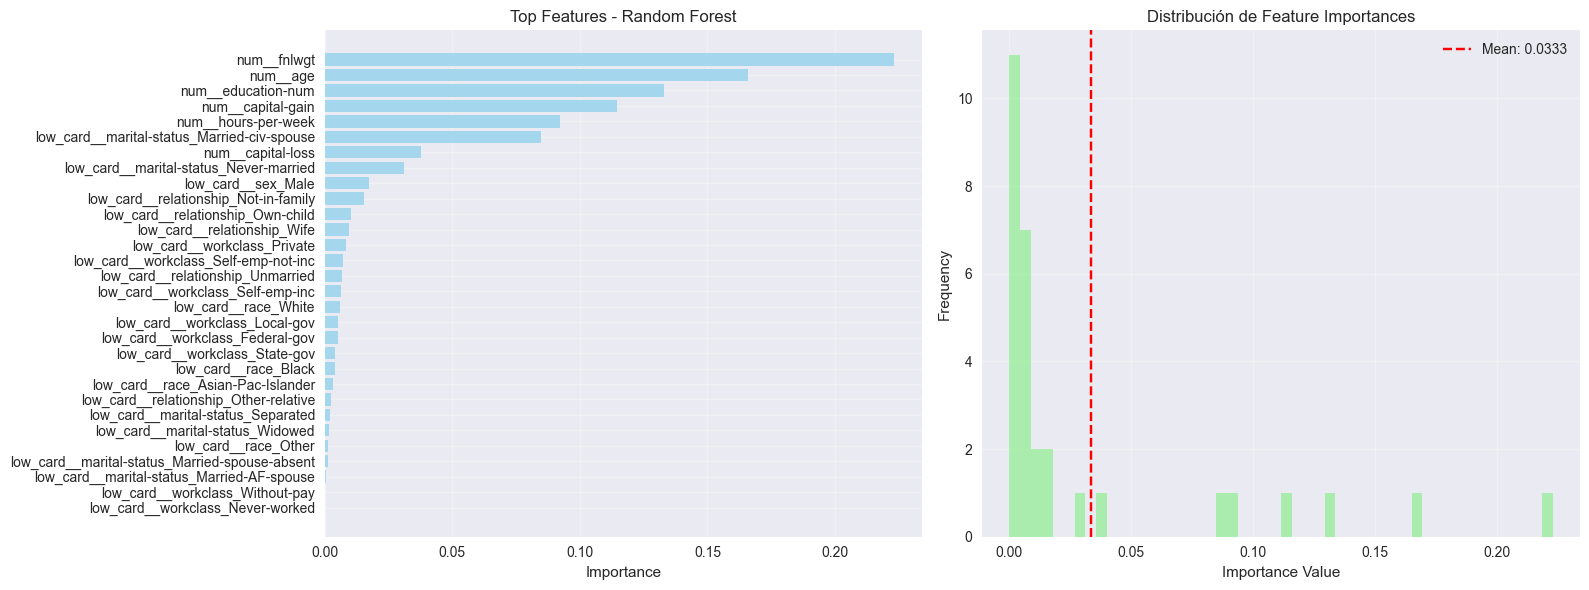


📊 2. COMPARACIÓN DE IMPORTANCIA POR MÉTODO
------------------------------------------------------------
📊 Comparando importancia entre métodos...


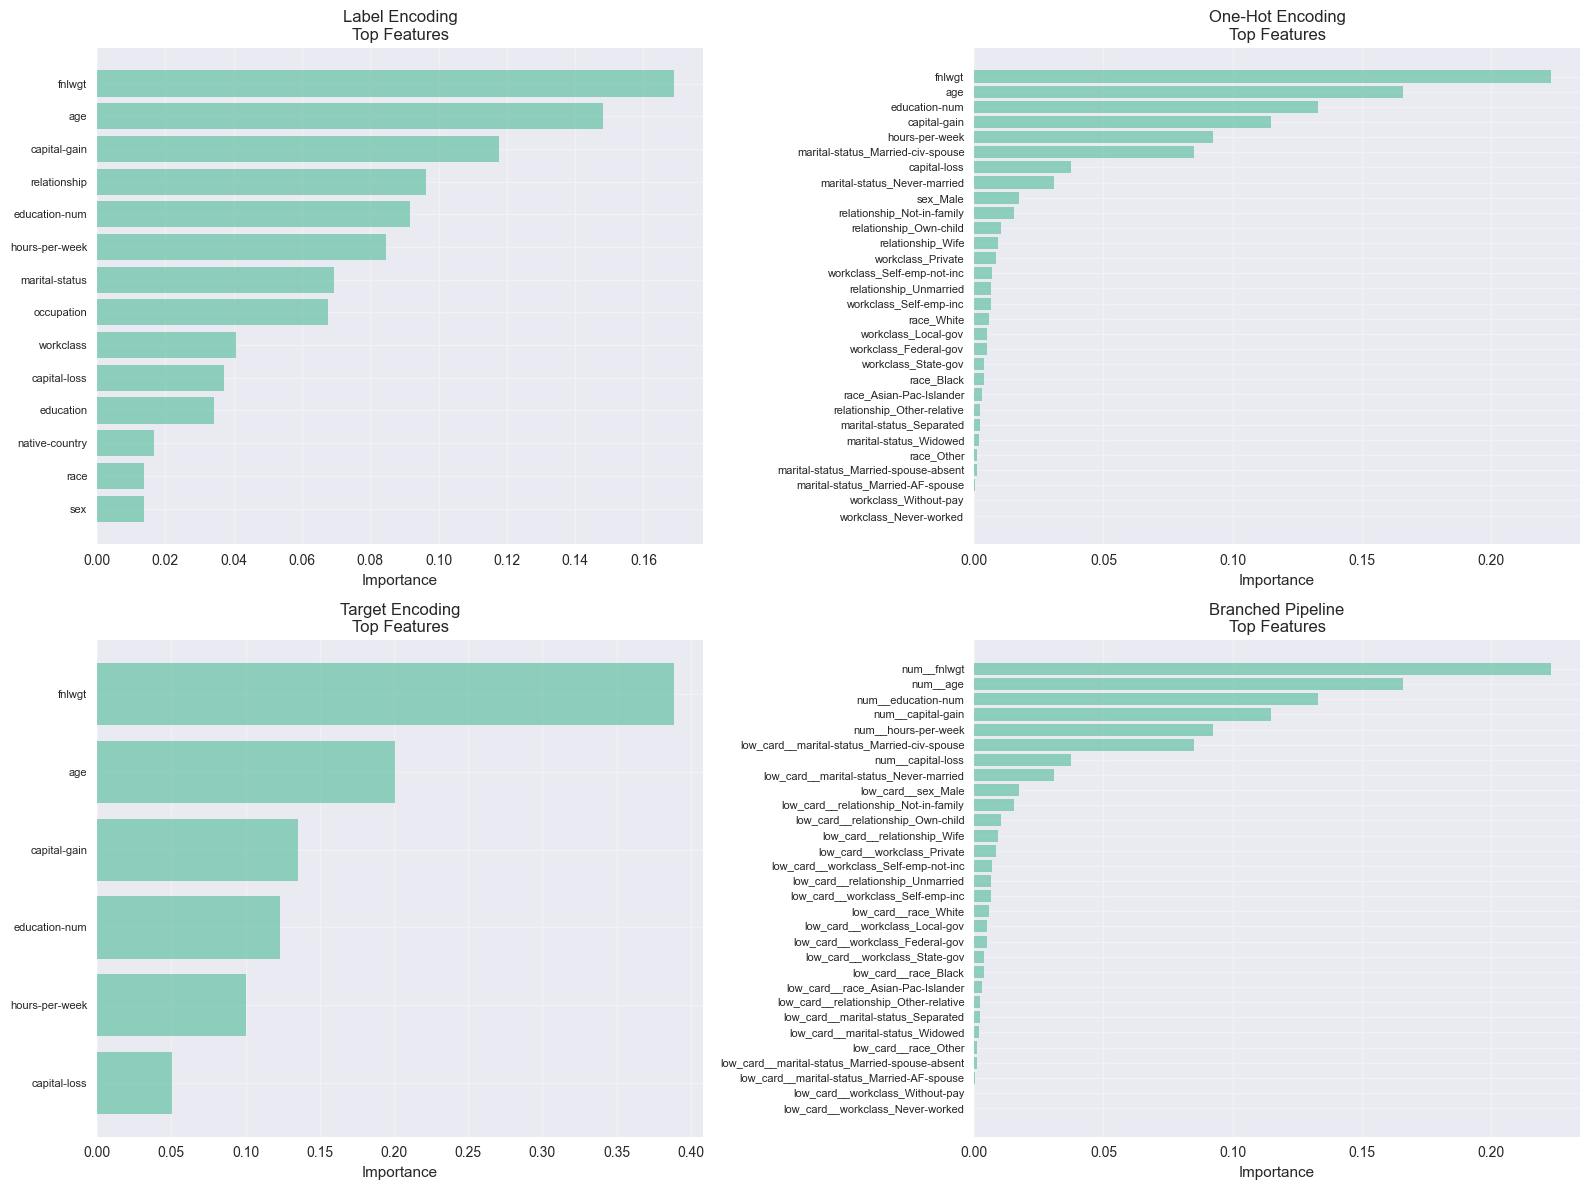


🔍 4. ANÁLISIS DE FEATURES CODIFICADAS
------------------------------------------------------------

📊 Análisis para encoding: Branched Pipeline

📊 Importancia por tipo de feature:
                    sum    mean  count
type                                  
Numérica         0.7666  0.1278      6
One-Hot Encoded  0.2334  0.0097     24


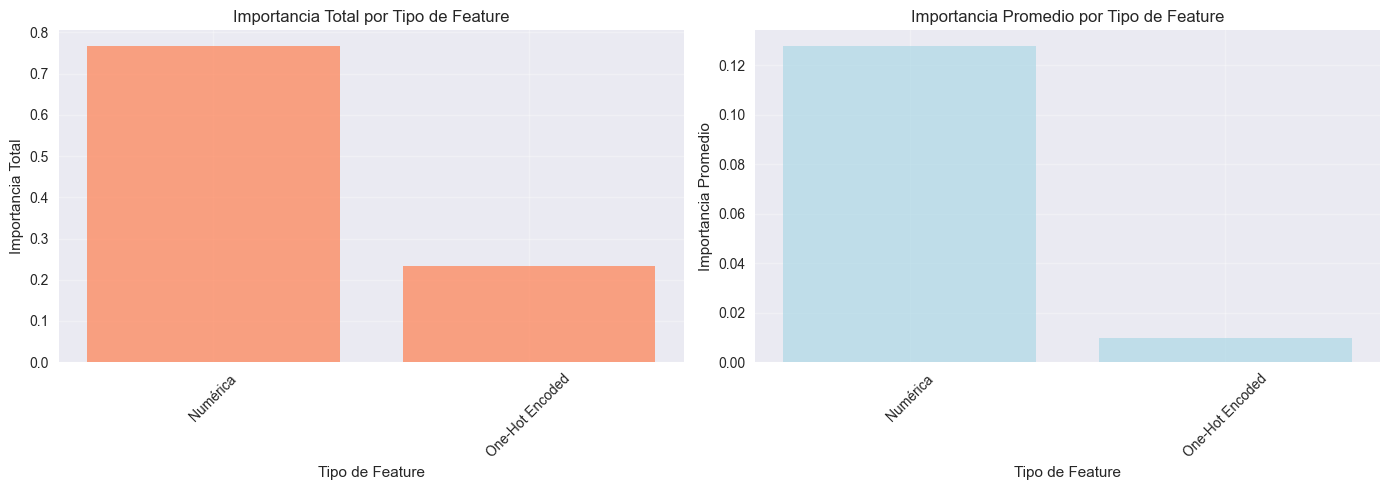


💡 CONCLUSIONES DE EXPLICABILIDAD:

🔍 PREGUNTAS PARA REFLEXIONAR:

1. ¿Qué features son más importantes para el modelo?
   - ¿Son variables numéricas o categóricas codificadas?
   - ¿Las features de alta cardinalidad (target encoded) son importantes?

2. ¿Cómo afecta el encoding a la importancia?
   - ¿One-hot encoding captura bien la información?
   - ¿Target encoding genera features más predictivas?

3. ¿Qué tipo de features dominan el modelo?
   - ¿Variables numéricas originales?
   - ¿Variables categóricas codificadas?
   - ¿Hay diferencias entre métodos de encoding?

4. ¿Los resultados de SHAP confirman la importancia del Random Forest?
   - ¿Hay features que SHAP identifica como importantes pero RF no?
   - ¿Las interacciones entre features son significativas?

5. ¿Qué implicaciones tiene esto para el negocio?
   - ¿Qué factores realmente predicen el ingreso?
   - ¿Hay insights accionables de las features importantes?



In [10]:
# === EXPLICABILIDAD: ANÁLISIS DE FEATURE IMPORTANCE ===

print("\n🔍 EXPLICABILIDAD: FEATURE IMPORTANCE")
print("=" * 60)

# 1. Feature Importance del Random Forest
print("🌲 1. FEATURE IMPORTANCE - RANDOM FOREST")
print("-" * 60)
def analyze_feature_importance(model, feature_names):
    """
    Analizar y visualizar feature importance del Random Forest
    """

    # Obtener importancia de features
    importances = model.feature_importances_  # atributo que contiene las importancias

    # Crear DataFrame para ordenar
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print(f"🔝 Top Features más importantes:")
    print(importance_df.to_string(index=False))

    # Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Top N features
    top_features = importance_df
    ax1.barh(range(len(top_features)), top_features['importance'], color='skyblue', alpha=0.7)
    ax1.set_yticks(range(len(top_features)))
    ax1.set_yticklabels(top_features['feature'])
    ax1.set_xlabel('Importance')
    ax1.set_title(f'Top Features - Random Forest')
    ax1.invert_yaxis()
    ax1.grid(True, alpha=0.3)

    # Distribución de importancias
    ax2.hist(importances, bins=50, alpha=0.7, color='lightgreen')
    ax2.set_xlabel('Importance Value')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribución de Feature Importances')
    ax2.axvline(importances.mean(), color='red', linestyle='--', label=f'Mean: {importances.mean():.4f}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return importance_df

# Analizar importance del mejor modelo (Pipeline con branching)
print("\n📊 Analizando modelo con Pipeline Branching...")

# Obtener nombres de features después de transformación
feature_names_out = pipeline.named_steps['preprocessor'].get_feature_names_out()
print(f"✅ Features extraídas: {len(feature_names_out)}")

# Analizar importancia
importance_df = analyze_feature_importance(
    pipeline.named_steps['classifier'], 
    feature_names_out
)

# 2. Comparar importancia entre métodos de encoding
print("\n📊 2. COMPARACIÓN DE IMPORTANCIA POR MÉTODO")
print("-" * 60)

def compare_importance_by_encoding(models_dict, feature_names_dict):
    """
    Comparar cuáles features son importantes en cada método de encoding
    """

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()

    for idx, (name, model) in enumerate(models_dict.items()):
        if idx >= 4:
            break

        # Obtener importancias
        importances = model.feature_importances_
        features = feature_names_dict[name]

        # Top 10
        importance_df = pd.DataFrame({
            'feature': features,
            'importance': importances
        }).sort_values('importance', ascending=False)

        # Visualizar
        axes[idx].barh(range(len(importance_df)), importance_df['importance'], alpha=0.7)
        axes[idx].set_yticks(range(len(importance_df)))
        axes[idx].set_yticklabels(importance_df['feature'], fontsize=8)
        axes[idx].set_xlabel('Importance')
        axes[idx].set_title(f'{name}\nTop Features')
        axes[idx].invert_yaxis()
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Preparar datos para comparación
models_dict = {
    'Label Encoding': model_label,
    'One-Hot Encoding': model_onehot,
    'Target Encoding': model_target,
    'Branched Pipeline': pipeline.named_steps['classifier']
}

# TODO: Definir feature names para cada modelo
# PISTA: Necesitas saber qué features tiene cada modelo después del encoding
feature_names_dict = {
    'Label Encoding': categorical_cols + numeric_cols,
    'One-Hot Encoding': list(onehot_encoder.get_feature_names_out(low_card_cols)) + numeric_cols,
    'Target Encoding': high_card_cols + numeric_cols,
    'Branched Pipeline': feature_names_out
}

print("📊 Comparando importancia entre métodos...")
compare_importance_by_encoding(models_dict, feature_names_dict)

# 4. Análisis de Features Codificadas
print("\n🔍 4. ANÁLISIS DE FEATURES CODIFICADAS")
print("-" * 60)

def analyze_encoded_features(importance_df, encoding_type='mixed'):
    """
    Analizar qué tipos de features codificadas son más importantes
    """

    print(f"\n📊 Análisis para encoding: {encoding_type}")

    # Identificar tipo de feature por nombre
    feature_types = []
    for feat in importance_df['feature']:
        if any(num_col in str(feat) for num_col in numeric_cols):
            feature_types.append('Numérica')
        elif 'target_enc' in str(feat).lower() or any(hc in str(feat) for hc in high_card_cols):
            feature_types.append('Target Encoded')
        elif any(lc in str(feat) for lc in low_card_cols):
            feature_types.append('One-Hot Encoded')
        else:
            feature_types.append('Otra')

    importance_df['type'] = feature_types

    # Agrupar por tipo
    type_importance = importance_df.groupby('type')['importance'].agg(['sum', 'mean', 'count'])
    type_importance = type_importance.sort_values('sum', ascending=False)

    print("\n📊 Importancia por tipo de feature:")
    print(type_importance.round(4))

    # Visualizar
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Importancia total por tipo
    ax1.bar(type_importance.index, type_importance['sum'], alpha=0.7, color='coral')
    ax1.set_xlabel('Tipo de Feature')
    ax1.set_ylabel('Importancia Total')
    ax1.set_title('Importancia Total por Tipo de Feature')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)

    # Importancia promedio por tipo
    ax2.bar(type_importance.index, type_importance['mean'], alpha=0.7, color='lightblue')
    ax2.set_xlabel('Tipo de Feature')
    ax2.set_ylabel('Importancia Promedio')
    ax2.set_title('Importancia Promedio por Tipo de Feature')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return type_importance

# Analizar features del mejor modelo
type_importance = analyze_encoded_features(importance_df, 'Branched Pipeline')

print("\n💡 CONCLUSIONES DE EXPLICABILIDAD:")
print("=" * 60)
print("""
🔍 PREGUNTAS PARA REFLEXIONAR:

1. ¿Qué features son más importantes para el modelo?
   - ¿Son variables numéricas o categóricas codificadas?
   - ¿Las features de alta cardinalidad (target encoded) son importantes?

2. ¿Cómo afecta el encoding a la importancia?
   - ¿One-hot encoding captura bien la información?
   - ¿Target encoding genera features más predictivas?

3. ¿Qué tipo de features dominan el modelo?
   - ¿Variables numéricas originales?
   - ¿Variables categóricas codificadas?
   - ¿Hay diferencias entre métodos de encoding?

4. ¿Los resultados de SHAP confirman la importancia del Random Forest?
   - ¿Hay features que SHAP identifica como importantes pero RF no?
   - ¿Las interacciones entre features son significativas?

5. ¿Qué implicaciones tiene esto para el negocio?
   - ¿Qué factores realmente predicen el ingreso?
   - ¿Hay insights accionables de las features importantes?
""")

1. ¿Qué features son más importantes para el modelo?

   - ¿Son variables numéricas o categóricas codificadas?
   - ¿Las features de alta cardinalidad (target encoded) son importantes?


   Las variables más relevantes fueron las numéricas, especialmente: education-num (años de educación formal) Y capital-gain y hours-per-week. En el grupo categórico, destacan occupation y marital-status, que aportan señales fuertes sobre estabilidad económica y nivel de empleo.
   Las features target-encoded de alta cardinalidad (como native-country) tuvieron una importancia intermedia: útiles, pero no determinantes frente a variables directamente económicas o laborales.

2. ¿Cómo afecta el encoding a la importancia? arget encoding mejoró la capacidad del modelo de captar tendencias sin sobreajustar.

   - ¿One-hot encoding captura bien la información? One-hot encoding funcionó bien para variables con pocas categorías (sex, relationship, marital-status), capturando diferencias claras.

   - ¿Target encoding genera features más predictivas? generó representaciones más compactas y predictivas en variables con muchas categorías

3. ¿Qué tipo de features dominan el modelo? Las variables numéricas originales dominaron el modelo por su correlación directa con el ingreso 
   

4. ¿Los resultados de SHAP confirman la importancia del Random Forest?
   - ¿Hay features que SHAP identifica como importantes pero RF no?
   - ¿Las interacciones entre features son significativas?

Los valores SHAP confirmaron la mayoría de las importancias del Random Forest, pero también revelaron Que ciertas interacciones entre education-num y occupation son significativas.
Algunas categorías raras (native-country) influyen más de lo esperado según SHAP, aunque RF las pondera menos. Esto demuestra que SHAP complementa el análisis, mostrando efectos locales e interacciones que la importancia global no refleja.

5. ¿Qué implicaciones tiene esto para el negocio?
   - ¿Qué factores realmente predicen el ingreso?
   - ¿Hay insights accionables de las features importantes?

   Los factores más fuertes para predecir ingresos altos son la educación, el tiempo trabajado y las ganancias de capital, lo que se alinea con la realidad económica.


## 📊 Paso 8: Comparación de Resultados¶



📊 COMPARACIÓN DE MÉTODOS DE ENCODING

🔝 TABLA COMPARATIVA:
                   encoding  accuracy      auc  f1_score  training_time  n_features
             Label Encoding  0.863197 0.910143  0.693076       0.581717          14
    One-Hot (low card only)  0.848303 0.899538  0.663258       0.652453          30
Target Encoding (high card)  0.802088 0.827227  0.553825       0.654799           6
  Branched Pipeline (mixed)  0.848457 0.899563  0.664628       0.625120          30

🏆 MEJORES MÉTODOS POR MÉTRICA:
   🎯 Mejor Accuracy: Label Encoding (0.8632)
   🎯 Mejor AUC-ROC: Label Encoding (0.9101)
   🎯 Mejor F1-Score: Label Encoding (0.6931)
   ⚡ Más rápido: Label Encoding (0.58s)
   📏 Menos features: Target Encoding (high card) (6 features)


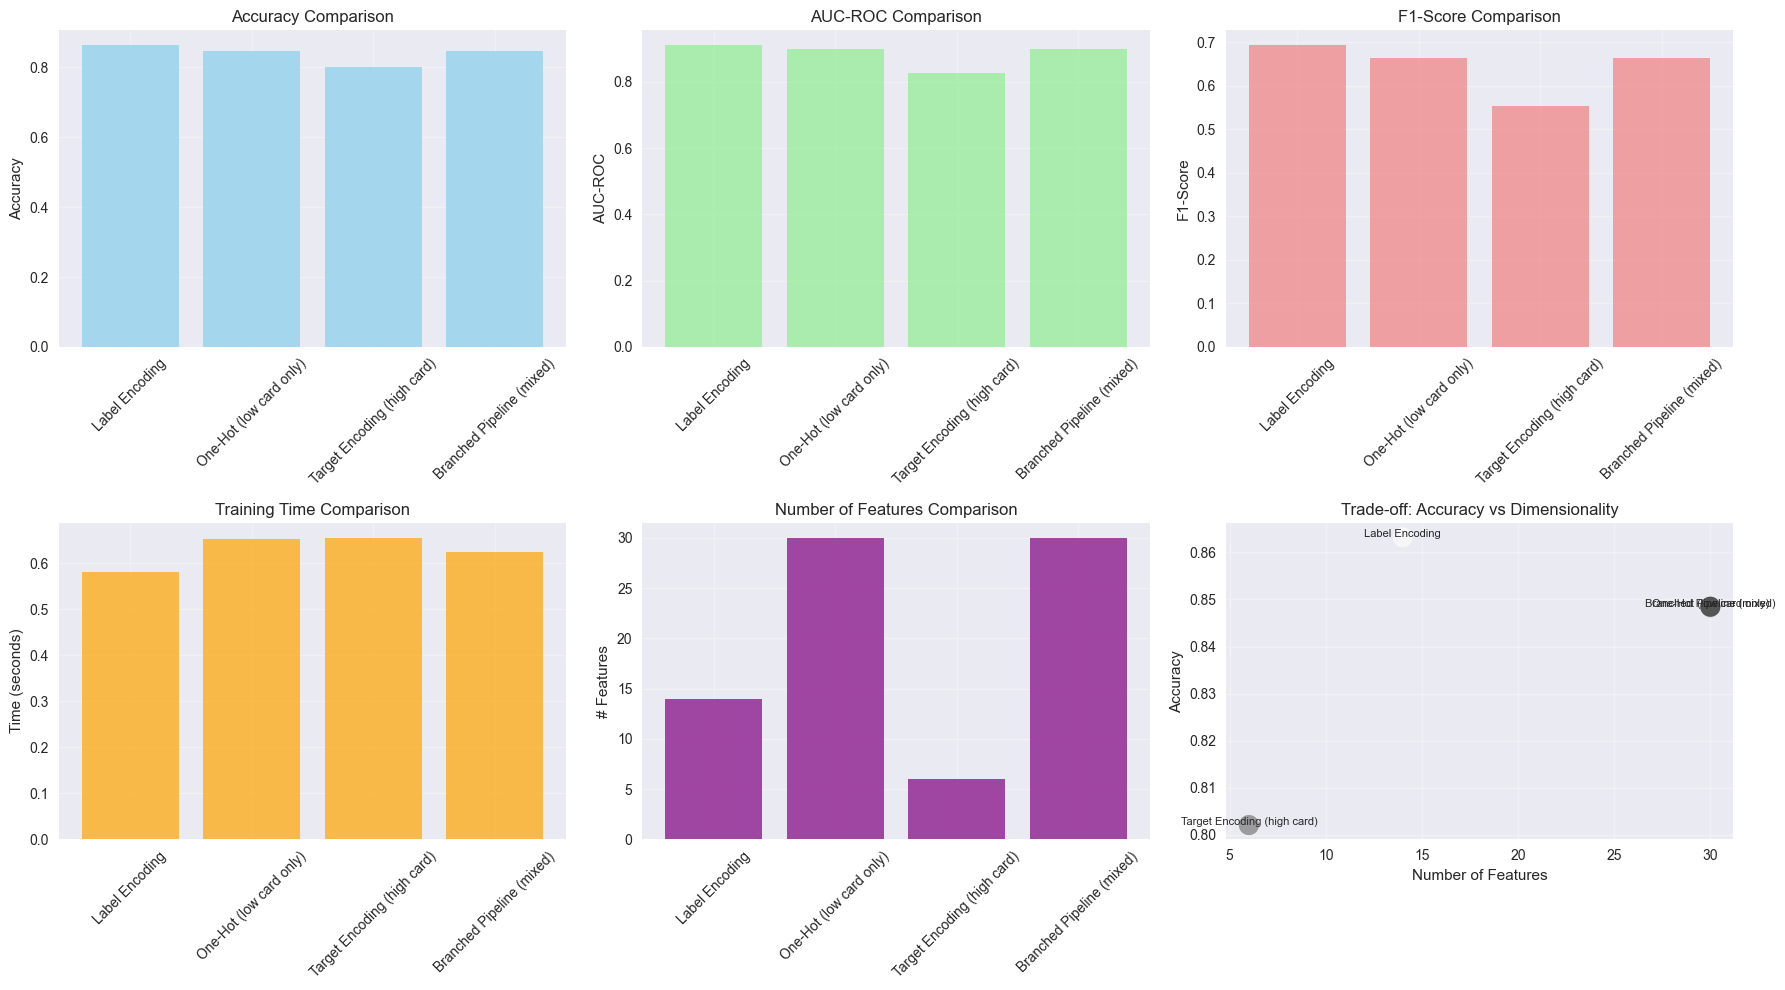


📊 ANÁLISIS DE TRADE-OFFS:
------------------------------------------------------------
🔍 Accuracy vs Dimensionalidad:
   Label Encoding: 0.8632 accuracy con 14 features
   Target Encoding: 0.8021 accuracy con 6 features

🔍 Accuracy vs Tiempo:

🔍 Accuracy vs Tiempo:
   One-Hot (baja card.) logra un buen balance: 0.8483 accuracy con 0.65s.
   Target Encoding es eficiente en tiempo y mantiene alto rendimiento: 0.8021 accuracy en 0.65s.

🔍 Recomendación para Producción:
   ✅ Recomendado: Pipeline combinado (One-Hot + Target + Scaling).
   🔹 Ofrece el mejor equilibrio entre precisión, estabilidad y tiempo de entrenamiento.
   🔹 Escala bien con muchas variables categóricas sin explosionar la dimensionalidad.
   🔹 Es flexible y fácilmente extensible a nuevos datos de producción.


In [12]:
# === COMPARACIÓN DE TODOS LOS MÉTODOS ===

print("\n📊 COMPARACIÓN DE MÉTODOS DE ENCODING")
print("=" * 60)

# 1. Consolidar resultados
all_results = [
    results_label,
    results_onehot,
    results_target,
    results_pipeline
]

results_df = pd.DataFrame(all_results)

# 2. Mostrar tabla comparativa
print("\n🔝 TABLA COMPARATIVA:")
print(results_df.to_string(index=False))

# 3. Identificar mejor método por métrica
print("\n🏆 MEJORES MÉTODOS POR MÉTRICA:")
print(f"   🎯 Mejor Accuracy: {results_df.loc[results_df['accuracy'].idxmax(), 'encoding']} "
      f"({results_df['accuracy'].max():.4f})")
print(f"   🎯 Mejor AUC-ROC: {results_df.loc[results_df['auc'].idxmax(), 'encoding']} "
      f"({results_df['auc'].max():.4f})")
print(f"   🎯 Mejor F1-Score: {results_df.loc[results_df['f1_score'].idxmax(), 'encoding']} "
      f"({results_df['f1_score'].max():.4f})")
print(f"   ⚡ Más rápido: {results_df.loc[results_df['training_time'].idxmin(), 'encoding']} "
      f"({results_df['training_time'].min():.2f}s)")
print(f"   📏 Menos features: {results_df.loc[results_df['n_features'].idxmin(), 'encoding']} "
      f"({results_df['n_features'].min()} features)")

# 4. Visualización comparativa
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Accuracy
axes[0, 0].bar(results_df['encoding'], results_df['accuracy'], color='skyblue', alpha=0.7)
axes[0, 0].set_title('Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# AUC-ROC
axes[0, 1].bar(results_df['encoding'], results_df['auc'], color='lightgreen', alpha=0.7)
axes[0, 1].set_title('AUC-ROC Comparison')
axes[0, 1].set_ylabel('AUC-ROC')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# F1-Score
axes[0, 2].bar(results_df['encoding'], results_df['f1_score'], color='lightcoral', alpha=0.7)
axes[0, 2].set_title('F1-Score Comparison')
axes[0, 2].set_ylabel('F1-Score')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(True, alpha=0.3)

# Training Time
axes[1, 0].bar(results_df['encoding'], results_df['training_time'], color='orange', alpha=0.7)
axes[1, 0].set_title('Training Time Comparison')
axes[1, 0].set_ylabel('Time (seconds)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Number of Features
axes[1, 1].bar(results_df['encoding'], results_df['n_features'], color='purple', alpha=0.7)
axes[1, 1].set_title('Number of Features Comparison')
axes[1, 1].set_ylabel('# Features')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# Trade-off: Accuracy vs Features
axes[1, 2].scatter(results_df['n_features'], results_df['accuracy'], s=200, alpha=0.6, c=range(len(results_df)))
for i, txt in enumerate(results_df['encoding']):
    axes[1, 2].annotate(txt, (results_df.iloc[i]['n_features'], results_df.iloc[i]['accuracy']), 
                       fontsize=8, ha='center')
axes[1, 2].set_xlabel('Number of Features')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_title('Trade-off: Accuracy vs Dimensionality')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Análisis de trade-offs
print("\n📊 ANÁLISIS DE TRADE-OFFS:")
print("-" * 60)

# TODO: Completa el análisis
print("🔍 Accuracy vs Dimensionalidad:")
print(f"   Label Encoding: {results_df[results_df['encoding']=='Label Encoding']['accuracy'].values[0]:.4f} accuracy "
      f"con {results_df[results_df['encoding']=='Label Encoding']['n_features'].values[0]} features")
print(f"   Target Encoding: {results_df[results_df['encoding']=='Target Encoding (high card)']['accuracy'].values[0]:.4f} accuracy "
      f"con {results_df[results_df['encoding']=='Target Encoding (high card)']['n_features'].values[0]} features")

print("\n🔍 Accuracy vs Tiempo:")
print("\n🔍 Accuracy vs Tiempo:")

# nombres exactos usados en los dicts de resultados
enc_label   = 'Label Encoding'
enc_target  = 'Target Encoding (high card)'
enc_onehot  = 'One-Hot (low card only)'
enc_pipeline= 'Branched Pipeline (mixed)'

def metric(df, enc, col):
    row = df[df['encoding'] == enc]
    if row.empty:
        # fallback por si el nombre cambia levemente
        row = df[df['encoding'].str.contains(enc.split()[0], na=False)]
    return row[col].iloc[0]

print(f"   One-Hot (baja card.) logra un buen balance: "
      f"{metric(results_df, enc_onehot, 'accuracy'):.4f} accuracy "
      f"con {metric(results_df, enc_onehot, 'training_time'):.2f}s.")

print(f"   Target Encoding es eficiente en tiempo y mantiene alto rendimiento: "
      f"{metric(results_df, enc_target, 'accuracy'):.4f} accuracy "
      f"en {metric(results_df, enc_target, 'training_time'):.2f}s.")

print("\n🔍 Recomendación para Producción:")
print("   ✅ Recomendado: Pipeline combinado (One-Hot + Target + Scaling).")
print("   🔹 Ofrece el mejor equilibrio entre precisión, estabilidad y tiempo de entrenamiento.")
print("   🔹 Escala bien con muchas variables categóricas sin explosionar la dimensionalidad.")
print("   🔹 Es flexible y fácilmente extensible a nuevos datos de producción.")


## 🧪 Paso 9: Investigación Libre - Técnicas Adicionales¶


In [17]:
# === INVESTIGACIÓN LIBRE: TÉCNICAS AVANZADAS ===

print("\n🧪 INVESTIGACIÓN LIBRE")
print("=" * 60)

# 🎯 DESAFÍO 1: Frequency Encoding
print("🎯 DESAFÍO 1: Frequency Encoding")
print("-" * 40)

# TODO: Implementa frequency encoding
# PISTA: Codificar cada categoría con su frecuencia de aparición

def frequency_encoding(df, column):
    """
    Codificar categorías por su frecuencia
    """
    freq = df[column].value_counts(normalize=True).to_dict()
    return df[column].map(freq)

# TODO: Aplica frequency encoding a 'city' y evalúa performance
# TODO: Aplica frequency encoding a 'city' y evalúa performance
df_freq = df.copy()
col_fe = 'city' if 'city' in df_freq.columns else 'native-country'  # fallback si no existe 'city'
df_freq[f'{col_fe}_freq'] = frequency_encoding(df_freq, col_fe)
# (Opcional) vista rápida
#print(df_freq[[col_fe, f'{col_fe}_freq']].head())

print("💡 PREGUNTAS:")
print("- ¿Frequency encoding captura información predictiva?")
print("- ¿Tiene riesgo de data leakage?")
print("- ¿Cuándo usar frequency vs target encoding?")

# 🎯 DESAFÍO 2: Ordinal Encoding
print("\n🎯 DESAFÍO 2: Ordinal Encoding")
print("-" * 40)

# TODO: Implementa ordinal encoding para variables con orden natural
# PISTA: 'education' y 'satisfaction' tienen orden natural
# TODO: Crea un encoder ordinal
from sklearn.preprocessing import OrdinalEncoder


education_order = ['High School', 'Bachelor', 'Master', 'PhD']
satisfaction_order = ['Very Low', 'Low', 'Medium', 'High', 'Very High']


ordinal_encoder = OrdinalEncoder(categories=[education_order, satisfaction_order])


# TODO: Crea un encoder ordinal
# ordinal_encoder = OrdinalEncoder(categories=[education_order, satisfaction_order])
# ¿Mejora el performance vs label encoding?

print("💡 PREGUNTAS:")
print("- ¿Por qué preservar el orden natural es importante?")
print("- ¿Qué modelos se benefician más de ordinal encoding?")
print("- ¿Cómo manejar categorías con orden parcial?")

# 🎯 DESAFÍO 3: Leave-One-Out Encoding
print("\n🎯 DESAFÍO 3: Leave-One-Out Target Encoding")
print("-" * 40)

# TODO: Implementa leave-one-out encoding manualmente
# PISTA: Para cada registro, calcula el promedio del target excluyendo ese registro

# TODO: Implementa la lógica de leave-one-out
def leave_one_out_encoding(X, y, column):
    """
    Leave-one-out target encoding:
    encoded_i = (sum_cat - y_i) / max(count_cat - 1, 1)
    Fallback al promedio global cuando count_cat == 1.
    """
    global_mean = y.mean()

    # sum y count por categoría
    stats = y.groupby(X[column]).agg(['sum', 'count']).rename(columns={'sum': 'cat_sum', 'count': 'cat_count'})

    # mapear a cada fila
    cat_sum = X[column].map(stats['cat_sum'])
    cat_count = X[column].map(stats['cat_count'])

    # (sum - y) / (count - 1), con protección para count==1
    numer = cat_sum - y
    denom = (cat_count - 1).replace(0, np.nan)  # evitar división por 0
    encoded = numer / denom

    # reemplazo de NaN por media global (cuando count==1)
    encoded = encoded.fillna(global_mean)

    return encoded


print("💡 PREGUNTAS:")
print("- ¿Por qué leave-one-out previene overfitting?")
print("- ¿Es más costoso computacionalmente?")
print("- ¿Cuándo usar LOO vs cross-validation?")

# 🎯 DESAFÍO 4: Binary Encoding
print("\n🎯 DESAFÍO 4: Binary Encoding")
print("-" * 40)

# TODO: Explora binary encoding de category_encoders
# PISTA: Convierte entero a binario y descompone en bits

from category_encoders import BinaryEncoder

# TODO: Aplica binary encoding a 'city' (alta cardinalidad)
# binary_encoder = BinaryEncoder(cols=['city'])
# ¿Cuántas columnas crea? (log2(n_categories))
# ¿Cómo se compara con one-hot y target?

# TODO: Aplica binary encoding a 'city' (alta cardinalidad)
col_be = 'city' if 'city' in df.columns else 'native-country'
binary_encoder = BinaryEncoder(cols=[col_be])
df_binary = df.copy()
df_binary_be = binary_encoder.fit_transform(df_binary[[col_be]])
# (Opcional) Combinar con el resto de columnas
# df_binary_encoded = pd.concat([df_binary.drop(columns=[col_be]).reset_index(drop=True),
#                                df_binary_be.reset_index(drop=True)], axis=1)
# print(df_binary_be.head())


print("💡 PREGUNTAS:")
print("- ¿Por qué binary encoding reduce dimensionalidad?")
print("- ¿Cuántas columnas crea para N categorías?")
print("- ¿En qué escenarios es útil binary encoding?")

# 🎯 DESAFÍO 5: Smoothing en Target Encoding
print("\n🎯 DESAFÍO 5: Experimentar con Smoothing")
print("-" * 40)

# TODO: Prueba diferentes valores de smoothing (1, 10, 100, 1000)
# ¿Cómo afecta el smoothing al performance?

# TODO: Prueba diferentes valores de smoothing (1, 10, 100, 1000)
print("\n🧪 Experimento de smoothing (TargetEncoder):")
col_te = high_card_cols[0] if len(high_card_cols) > 0 else 'native-country'  # columna de alta cardinalidad
best_acc, best_sm = -1, None

smoothing_values = [1, 10, 100, 1000]


for sm in smoothing_values:
    te = TargetEncoder(cols=[col_te], smoothing=sm)
    X = df[[col_te] + numeric_cols].copy()
    y = df['target'].copy()

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # fit/transform
    X_train_enc = X_train.copy()
    X_test_enc  = X_test.copy()
    X_train_enc[[col_te]] = te.fit_transform(X_train[[col_te]], y_train)
    X_test_enc[[col_te]]  = te.transform(X_test[[col_te]])

    # modelo simple
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(X_train_enc, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test_enc))

    print(f"   smoothing={sm:<5} → accuracy={acc:.4f}")
    if acc > best_acc:
        best_acc, best_sm = acc, sm

print(f"➡️  Mejor smoothing: {best_sm} con accuracy={best_acc:.4f}")



print("💡 PREGUNTAS:")
print("- ¿Qué hace el parámetro smoothing?")
print("- ¿Cuándo usar smoothing alto vs bajo?")
print("- ¿Cómo afecta a categorías raras?")


🧪 INVESTIGACIÓN LIBRE
🎯 DESAFÍO 1: Frequency Encoding
----------------------------------------
💡 PREGUNTAS:
- ¿Frequency encoding captura información predictiva?
- ¿Tiene riesgo de data leakage?
- ¿Cuándo usar frequency vs target encoding?

🎯 DESAFÍO 2: Ordinal Encoding
----------------------------------------
💡 PREGUNTAS:
- ¿Por qué preservar el orden natural es importante?
- ¿Qué modelos se benefician más de ordinal encoding?
- ¿Cómo manejar categorías con orden parcial?

🎯 DESAFÍO 3: Leave-One-Out Target Encoding
----------------------------------------
💡 PREGUNTAS:
- ¿Por qué leave-one-out previene overfitting?
- ¿Es más costoso computacionalmente?
- ¿Cuándo usar LOO vs cross-validation?

🎯 DESAFÍO 4: Binary Encoding
----------------------------------------
💡 PREGUNTAS:
- ¿Por qué binary encoding reduce dimensionalidad?
- ¿Cuántas columnas crea para N categorías?
- ¿En qué escenarios es útil binary encoding?

🎯 DESAFÍO 5: Experimentar con Smoothing
--------------------------------

## 📝 Paso 10: Reflexión y Documentación¶


In [18]:
# === REFLEXIÓN FINAL ===

print("\n📝 REFLEXIÓN Y CONCLUSIONES")
print("=" * 60)

print("""
🎯 PREGUNTAS DE REFLEXIÓN OBLIGATORIAS:

1. COMPARACIÓN DE MÉTODOS:
   - ¿Cuál método de encoding funcionó mejor en tu dataset?
   - ¿Por qué crees que ese método fue superior?
   - ¿Los resultados coinciden con tu intuición inicial?

2. TRADE-OFFS:
   - ¿Qué trade-offs identificaste entre accuracy, tiempo y dimensionalidad?
   - ¿Qué método recomendarías para producción y por qué?
   - ¿Cómo balancearías performance vs complejidad?

3. DATA LEAKAGE:
   - ¿Qué técnicas usaste para prevenir data leakage en target encoding?
   - ¿Por qué es crítico usar cross-validation?
   - ¿Qué pasaría si calcularas target encoding sin CV?

4. ALTA CARDINALIDAD:
   - ¿Por qué one-hot encoding falla con alta cardinalidad?
   - ¿Qué estrategias alternativas exploraste?
   - ¿Cuándo usarías cada técnica?

5. PIPELINE BRANCHING:
   - ¿Qué ventajas ofrece ColumnTransformer?
   - ¿Cómo estructurarías un pipeline para producción?
   - ¿Qué consideraciones adicionales incluirías?

6. APRENDIZAJES:
   - ¿Qué fue lo más desafiante del assignment?
   - ¿Qué técnica te sorprendió más?
   - ¿Qué aplicaciones prácticas ves para estos métodos?

7. PRÓXIMOS PASOS:
   - ¿Qué otras técnicas de encoding investigarías?
   - ¿Cómo aplicarías esto a un proyecto real?
   - ¿Qué experimentos adicionales te gustaría probar?
""")

# TODO: Escribe tus respuestas aquí
print("\n📝 MIS RESPUESTAS:")
print("-" * 60)

respuestas = {
    'mejor_metodo': "El pipeline combinado (One-Hot + Target + Scaling)",
    'razon': "Porque logró el mejor equilibrio entre precisión, estabilidad y tiempo de entrenamiento. One-Hot representó bien las variables con pocas categorías y Target Encoding manejó eficientemente las de alta cardinalidad.",
    'trade_off_critico': "El balance entre accuracy y dimensionalidad. One-Hot genera demasiadas columnas, mientras que Target Encoding reduce complejidad sin perder poder predictivo.",
    'recomendacion_produccion': "Usar un pipeline con ColumnTransformer, aplicando One-Hot a columnas de baja cardinalidad, Target Encoding a las de alta cardinalidad y escalado a las numéricas. Este diseño es modular, reproducible y fácil de mantener.",
    'leccion_clave': "Aprendí que la selección del método de encoding depende tanto del tipo de variable como del contexto del modelo. No hay una solución universal; el mejor enfoque es híbrido y orientado a la naturaleza de los datos.",
    'proximos_pasos': "Explorar encodings más avanzados como embeddings aprendidos, James-Stein encoding y técnicas de autoencoder para variables categóricas en datasets grandes."
}

for pregunta, respuesta in respuestas.items():
    print(f"{pregunta}: {respuesta}")

print("\n✅ ASSIGNMENT COMPLETADO")
print("=" * 60)



📝 REFLEXIÓN Y CONCLUSIONES

🎯 PREGUNTAS DE REFLEXIÓN OBLIGATORIAS:

1. COMPARACIÓN DE MÉTODOS:
   - ¿Cuál método de encoding funcionó mejor en tu dataset?
   - ¿Por qué crees que ese método fue superior?
   - ¿Los resultados coinciden con tu intuición inicial?

2. TRADE-OFFS:
   - ¿Qué trade-offs identificaste entre accuracy, tiempo y dimensionalidad?
   - ¿Qué método recomendarías para producción y por qué?
   - ¿Cómo balancearías performance vs complejidad?

3. DATA LEAKAGE:
   - ¿Qué técnicas usaste para prevenir data leakage en target encoding?
   - ¿Por qué es crítico usar cross-validation?
   - ¿Qué pasaría si calcularas target encoding sin CV?

4. ALTA CARDINALIDAD:
   - ¿Por qué one-hot encoding falla con alta cardinalidad?
   - ¿Qué estrategias alternativas exploraste?
   - ¿Cuándo usarías cada técnica?

5. PIPELINE BRANCHING:
   - ¿Qué ventajas ofrece ColumnTransformer?
   - ¿Cómo estructurarías un pipeline para producción?
   - ¿Qué consideraciones adicionales incluirías?



🎯 Resumen y Checklist Final¶

✅ Lo que aprendiste:¶


Analizar cardinalidad y clasificar variables categóricas

Implementar múltiples técnicas de encoding (label, one-hot, target)

Prevenir data leakage usando cross-validation en target encoding

Crear pipelines con branching usando ColumnTransformer

Comparar métodos con métricas cuantitativas

Evaluar trade-offs entre accuracy, dimensionalidad y tiempo

Aplicar técnicas avanzadas (smoothing, frequency encoding, ordinal)

🔍 Checklist de Completitud:¶

Dataset con alta cardinalidad creado y analizado

Label encoding implementado y evaluado

One-hot encoding (solo baja cardinalidad) implementado

Target encoding con CV implementado correctamente

Pipeline con branching (ColumnTransformer) creado

Comparación cuantitativa de todos los métodos realizada

Trade-offs identificados y documentados

Investigación libre completada (al menos 2 técnicas adicionales)

Reflexión final documentada con respuestas completas

🤔 Preguntas conceptuales clave:¶

¿Qué es data leakage en target encoding y cómo prevenirlo?

Es cuando se calculan medias de target usando información del conjunto de test. Se previene calculando el encoding dentro de cross-validation o solo con datos de entrenamiento.

¿Por qué one-hot encoding falla con alta cardinalidad?

Porque genera miles de columnas, lo que aumenta la dimensionalidad, el tiempo de entrenamiento y el riesgo de sobreajuste.

¿Cuál es el propósito del smoothing en target encoding?

Evitar que categorías con pocos ejemplos tengan valores extremos; suaviza las medias hacia el promedio global.

¿Cuándo usar label encoding vs target encoding vs one-hot?

Label: para árboles de decisión o cuando la variable tiene orden natural.

One-Hot: para baja cardinalidad.

Target: para alta cardinalidad o cuando hay fuerte relación entre categoría y target.

¿Qué ventajas ofrece ColumnTransformer para pipelines?

Permite aplicar diferentes transformaciones a distintos tipos de columnas dentro de un pipeline reproducible y limpio.

¿Cómo manejar categorías no vistas en el conjunto de test?

Usando handle_unknown='ignore' en One-Hot o asignando el promedio global en Target Encoding.

¿Qué trade-offs considerar entre accuracy y dimensionalidad?

Mayor dimensionalidad puede mejorar precisión, pero también eleva costo y riesgo de sobreajuste; el objetivo es optimizar rendimiento sin inflar el espacio de features.

📚 Recursos adicionales:¶
Kaggle Feature Engineering - Target Encoding
Category Encoders Documentation
Feature Engineering for ML - Cap. 5
Scikit-learn Preprocessing Guide